In [1]:
import os
import re
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import utils as u

In [2]:
import tensorflow as tf
import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import ensemble
from sklearn import pipeline
from sklearn import linear_model
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import neural_network
from sklearn import feature_selection

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [4]:
sample_size = 5
metrics = ['neg_mean_absolute_error', 'neg_median_absolute_error', 'r2', 'explained_variance', 'max_error']
cv = 3
random_seed = 42
var_threshold = 0.9
test_size = 0.3
preferred_score = 'r2'
tf.set_random_seed(random_seed)
missing_transport_factor = 1
min_outlier_factor = -2

# 2.2 Algorithms and Techniques

# Import Data

In [5]:
# create query client
queries = u.get_queries('queries')
bq_client = bigquery.Client()

# import main dataset
data = u.get_data(queries, 'training_data.sql', bq_client)
data['post_code'] = data['address'].str.extract(r'.*(\d{4}).*', expand=False)
data = data.groupby('ad_id').apply(lambda obj: obj.sample(n=sample_size, random_state=random_seed) if len(obj) > sample_size else obj.sample(len(obj)))

# import post code dataset
post_codes = u.get_data(queries, 'post_code_area_name.sql', bq_client).set_index('post_code', drop=True)
data = data.merge(post_codes, how='left', left_on='post_code', right_index=True)
data['address_oslo'] = data['settlement_name'].apply(lambda s_n: 1 if s_n == 'oslo' else 0)
new_building_pct = pd.Series(data[data.new_building == True]\
                             .groupby('area_name')['ad_id'].count()\
                             .div(data\
                                  .groupby('area_name')['ad_id'].count()),
                             name='area_new_building_pct')

data = data.merge(new_building_pct, how='left', left_on='area_name', right_index=True)
historic = pd.pivot_table(data=data, index='post_code', values='price_per_sq_m', aggfunc='median').rename(columns={'price_per_sq_m': 'median_price_per_sq_m'})
data = data.merge(historic, how='left', left_on='post_code', right_index=True)

# import google maps data
gmaps = u.get_data(queries, 'all_post_code_places.sql', bq_client)
place_counts = pd.pivot_table(data=gmaps, index='post_code', columns='place_type', values='attribute_value', aggfunc='count', fill_value=0)
_slice = gmaps[gmaps.place_attribute == 'rating']
place_ratings = pd.pivot_table(data=_slice, index='post_code', columns='place_type', values='attribute_value', aggfunc='mean')
_slice = gmaps[gmaps.place_attribute == 'price_level']
place_prices = pd.pivot_table(data=_slice, index='post_code', columns='place_type', values='attribute_value', aggfunc='mean')
gmaps_data = place_counts.join(place_ratings, rsuffix='_rating').join(place_prices, rsuffix='_price')
gmaps_data.dropna(axis=1, inplace=True)
data = data.merge(gmaps_data, how='left', left_on='post_code', right_index=True)

# import national health institute data
fhi_data = u.get_data(queries, 'full_fhi_data.sql', bq_client)
fhi_data_latest = pd.DataFrame(index=fhi_data.area_name.unique())
for dataset in fhi_data.dataset.unique():
    to_join = fhi_data[fhi_data.dataset == dataset]
    latest_year = to_join[to_join.value.notna()].year.max()
    to_join_latest_year = to_join[to_join.year == latest_year]
    to_join_pivot = pd.pivot_table(data=to_join_latest_year,
                                   index='area_name',
                                   values='value').rename(columns={'value': dataset})
    fhi_data_latest = fhi_data_latest.join(to_join_pivot)
data = data.merge(fhi_data_latest, how='left', left_on='area_name', right_index=True)

# Impute Data

In [6]:
data.isna().sum(axis=0).sort_values(ascending=False)[:10]

apt_id                   2090
floor                     834
time_s                    192
num_bedrooms               92
area_new_building_pct      42
immigrant_pct               8
low_income_households       8
uni_graduates               8
income_inequality           8
cramped_spaces              8
dtype: int64

In [7]:
data['time_s'].fillna(data['time_s'].max() * missing_transport_factor, inplace=True)
data['floor'].fillna(1, inplace=True)
data['num_bedrooms'].fillna(0, inplace=True)
data['median_price_per_sq_m'].fillna(data.median_price_per_sq_m.median(), inplace=True)
data['uni_graduates'].fillna(data.uni_graduates.mean(), inplace=True)
data['area_new_building_pct'] = data.area_new_building_pct.fillna(data.area_new_building_pct.mean())
data.fillna(0, inplace=True)

In [8]:
data.drop(['address', 'post_code', 'area_name', 'settlement_name', 'ad_id', 'apt_id'], axis=1, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3675 entries, (69757913, 11) to (154331002, 5174)
Columns: 120 entries, time_s to immigrant_pct
dtypes: float64(116), int64(4)
memory usage: 3.4 MB


# Define X and y

In [10]:
X = data.drop('price_per_sq_m', axis=1)
y = data['price_per_sq_m']

# Create Pipeline

In [11]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [12]:
estimators = [# KerasRegressor(build_fn=create_model, epochs=500, batch_size=700, verbose=False),
              ensemble.AdaBoostRegressor(random_state=random_seed),
              linear_model.LinearRegression(),
              # neighbors.KNeighborsRegressor(),
              # naive_bayes.ComplementNB(),
              # neural_network.MLPRegressor(random_state=random_seed)
]

In [13]:
steps = [# ('detect_outliers', 'passthrough'),
         ('var_selector', feature_selection.VarianceThreshold()),
         ('rfe', feature_selection.RFECV(linear_model.LinearRegression())),
         ('scale', preprocessing.MinMaxScaler()),
         ('normalize', preprocessing.Normalizer()),
         ('model', 'passthrough')]

In [14]:
model_pipeline = pipeline.Pipeline(steps)

In [15]:
param_grid = {# 'detect_outliers': [neighbors.LocalOutlierFactor(contamination=0.22)],
              'var_selector__threshold': np.arange(0.5, 1, 0.1),
              'rfe__estimator': estimators,
              'rfe__cv': [cv],
              'rfe__scoring': metrics,
              'model': estimators}

In [16]:
grid = model_selection.GridSearchCV(model_pipeline, cv=cv, n_jobs=1, param_grid=param_grid, scoring='neg_mean_absolute_error')

In [17]:
grid.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('var_selector',
                                        VarianceThreshold(threshold=0.0)),
                                       ('rfe',
                                        RFECV(cv='warn',
                                              estimator=LinearRegression(copy_X=True,
                                                                         fit_intercept=True,
                                                                         n_jobs=None,
                                                                         normalize=False),
                                              min_features_to_select=1,
                                              n_jobs=None, scoring=None, step=1,
                                              verbose=0)),
                                       ('scale',
                                        MinMaxScale

In [18]:
grid.best_score_

-10829.609051279058

In [19]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('var_selector', VarianceThreshold(threshold=0.7)),
                ('rfe',
                 RFECV(cv=3,
                       estimator=LinearRegression(copy_X=True,
                                                  fit_intercept=True,
                                                  n_jobs=None,
                                                  normalize=False),
                       min_features_to_select=1, n_jobs=None,
                       scoring='neg_median_absolute_error', step=1,
                       verbose=0)),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [20]:
estimator = grid.best_estimator_

In [21]:
# Recursive feature elimination results
# plt.figure()
# plt.xlabel('n_features')
# plt.ylabel('error')
# plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
# plt.show()

In [22]:
# optimal_n_features = rfe.grid_scores_.argmax() + 1
# print(f'The optimal number of features is: {optimal_n_features}')

In [23]:
# feature_ranking = pd.Series(rfe.ranking_, index=X.columns)

In [24]:
y_pred = pd.Series(estimator.predict(X), index=y.index, name='predicted')

In [25]:
def get_learning_curves(estimator, X, y, train_sizes=np.arange(0.1, 1.1, 0.1), score='neg_mean_absolute_error', cv=5):
    train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator, X, y, train_sizes=train_sizes, scoring=score, cv=cv)
    curve_data = pd.DataFrame(columns = range(train_scores.shape[1]))
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        curve_data = curve_data.append(frame, ignore_index = True)
    curve_data = curve_data.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')
    return curve_data


def get_cv_res(estimator, X, y, score=['neg_mean_absolute_error'], cv=5):
    cross_val = model_selection.cross_validate(estimator, X, y, scoring=score, cv=cv)
    return cross_val


def print_cv_res(cross_val):
    for key, val in cross_val.items():
        print('Mean {}, {:.2f}'.format(key, val.mean()))

In [26]:
learning_curve_res = get_learning_curves(estimator, X, y, score='neg_mean_absolute_error')

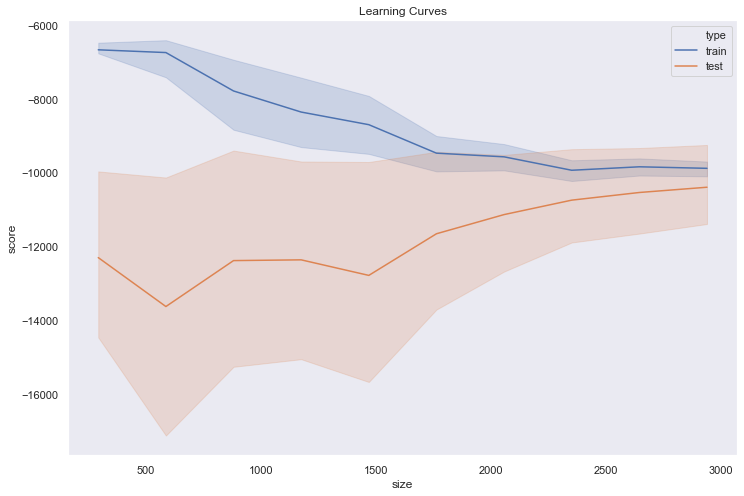

In [27]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

## Display Predicted VS Actual

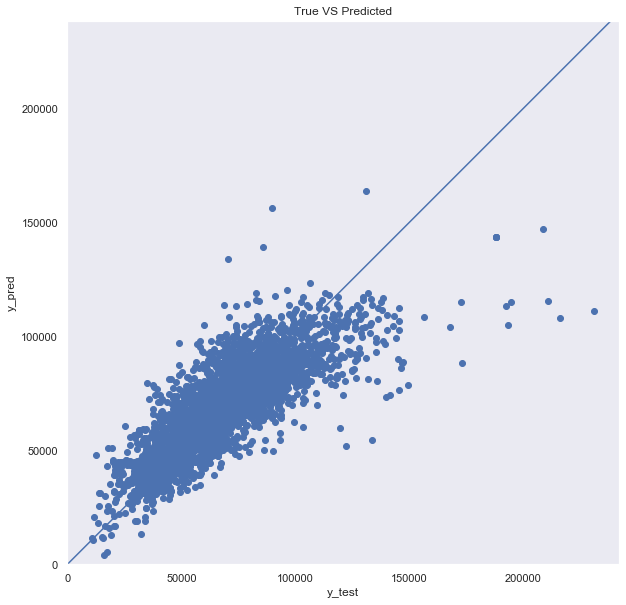

In [28]:
plt.scatter(y, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-5e7, 5e7], [-5e7, 5e7])
plt.title('True VS Predicted')
plt.show()

## Display Error Spread

In [30]:
to_plot = X.join(y_pred).join(y)
to_plot['pred_diff'] = to_plot['predicted'] - to_plot['price_per_sq_m']

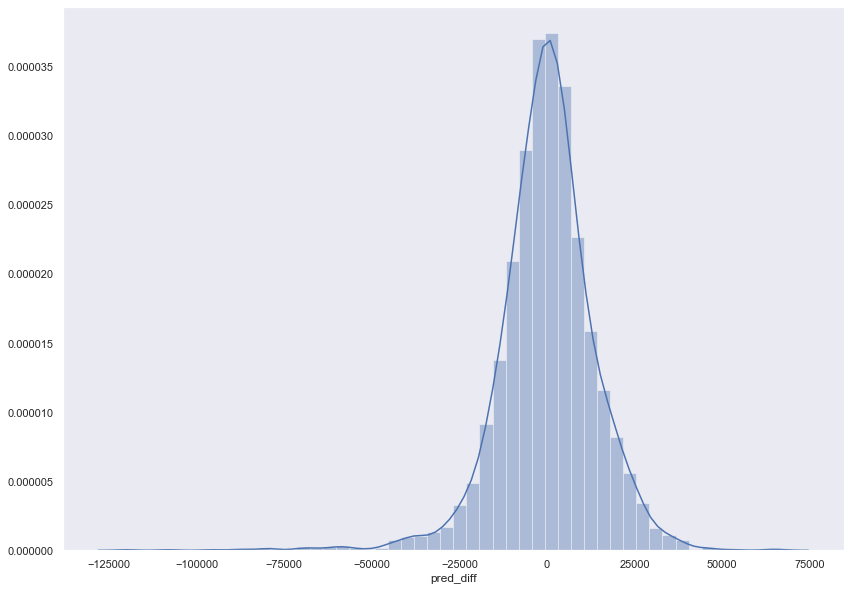

In [31]:
sns.distplot(to_plot.pred_diff)
plt.show()

# Display Feature Importances

In [ ]:
# feature_importances = pd.Series(estimator.named_steps['model'].feature_importances_, index=selected_features).sort_values(ascending=True)

In [ ]:
# to_plot = feature_importances[feature_importances > 0.01]
# plt.yticks(range(len(to_plot)), to_plot.index)
# plt.title('Feature Importances')
# plt.barh(range(len(to_plot)), to_plot)
# plt.show()

In [ ]:
# feature_importances[feature_importances > 0.01].to_frame(name='importance').style.format('{:.1%}')